In [1]:
from highcharts import Highmap
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import requests

from state_details import electoral_college_votes_by_state, hc_keys_by_state

### Get population by US county from the US Census API

In [2]:
# API key requested from www.census.gov
f = open('/Users/brianna/Dropbox/data_project/census_api_key.txt', 'r')
api_key = f.readline()[:-1]
f.close()

In [3]:
# Once the data is downloaded, just save it to keep from having to continually re-request from the Census API
upload_saved_file = True

In [4]:
# Get population by US county (either from API or from saved file)
if upload_saved_file:
    print('Reading population data locally')
    population = pd.DataFrame.from_csv('population_by_us_county.csv')
else:
    print('Grabbing population data from US Census')
    url = 'http://api.census.gov/data/2015/pep/population?get=POP,GEONAME&for=%s:*&DATE=8&key=%s' % ('county', api_key)
    response = requests.get(url)

    if response.status_code != 200:
        raise ValueError('Unexpected status code: %s' % response.status_code)
    else:
        data = eval(response.content)
        headers = data.pop(0)
        population = pd.DataFrame(data, columns=headers)
        population['state'] = population.state.apply(lambda x: int(x))
        # Replace commas with semicolons and save as csv file
        population['GEONAME'] = population.GEONAME.apply(lambda x: x.replace(',', ';'))
        population.to_csv('population_by_us_county.csv')

Reading population data locally


### Remove non-voting states

In [5]:
print('%s unique states' % population.state.nunique())
print('Remove Puerto Rico (72)')
pop_df = population.drop(population[population.state.isin([72])].index)
print('%s unique states' % pop_df.state.nunique())

52 unique states
Remove Puerto Rico (72)
51 unique states


### Split GEONAME into County, State, Division, Region, Country

In [6]:
pop_df.rename(columns={'state': 'state_no', 'county': 'county_no', 'POP': 'population'}, inplace=True)
pop_df['county'] = pop_df.GEONAME.apply(lambda x: x.split('; ')[0])
pop_df['state'] = pop_df.GEONAME.apply(lambda x: x.split('; ')[1])
pop_df['division'] = pop_df.GEONAME.apply(lambda x: x.split('; ')[2])
pop_df['region'] = pop_df.GEONAME.apply(lambda x: x.split('; ')[3])

In [7]:
# Add hc-keys for plotting in Highcharts
pop_df['hc_key'] = pop_df.state.apply(lambda x: hc_keys_by_state[x])

In [8]:
# Convert population (POP) from string to int
pop_df['population'] = pop_df.population.apply(lambda x: int(x))

### Get population by state

In [58]:
state_pop = pop_df.groupby('hc_key').sum()
state_pop['hc_key'] = state_pop.index

In [59]:
state_by_hc_key = {v: k for k, v in hc_keys_by_state.iteritems()}
state_pop['state'] = state_pop.hc_key.apply(lambda x: state_by_hc_key[x])

### Include electoral college votes by state

In [60]:
state_pop['ec_votes'] = state_pop.state.apply(lambda x: electoral_college_votes_by_state[x])
state_pop['ec_votes_per_voter'] = state_pop.ec_votes / state_pop.population

# These numbers are so small that they're kind of hard to understand so instead let's get the "average"
# portion of an electoral college vote and look at percentage more or less than that.
ave_ec_votes_per_voter = sum(state_pop.ec_votes) * 1.0 / sum(state_pop.population)
state_pop['ec_votes_per_voter_percent_of_average'] = state_pop.ec_votes_per_voter * 100.0 / ave_ec_votes_per_voter
state_pop['ec_votes_per_voter_percent_of_average'] = state_pop.ec_votes_per_voter_percent_of_average.apply(lambda x: round(x))

### Plot By State

In [61]:
# Fill in the data structure for plotting
state_pop_data = []

plot_titles = {'population': 'US Population by State',
               'ec_votes_per_voter': 'Electoral College Vote Portion Per Voter',
               'ec_votes_per_voter_percent_of_average': 'Percent of National Average Representation Per Voter'}

# plot_measure = 'population'
# plot_measure = 'ec_votes_per_voter'
plot_measure = 'ec_votes_per_voter_percent_of_average'

for k in state_pop.index:
    state_pop_data.append({'hc-key': k, 'value': state_pop[plot_measure][k]})

In [35]:
options = { # construct option dict
                                   
    'chart' :{ 'renderTo' : 'container'
    },
                           
    'title' : {
        'text' : plot_titles[plot_measure]
    },

    'mapNavigation': {
        'enabled': True,
        'buttonOptions': {
            'verticalAlign': 'bottom'
        }
    },
    'colorAxis': {
                'type': 'logarithmic',
#                 'min': 5e5,
                'minColor': '#FFFFFF', # white
                'maxColor': '#BC0AD1', # dark magenta
#                 'maxColor': '#699C02', # dark green      
            },
} 

In [73]:
H = Highmap(width = 650, height = 500)

H.set_dict_options(options) # set options
H.add_data_set(state_pop_data, 'map', 'Population', joinBy='hc-key', # set dataset [label string in json, label string in local dicts]
                states={
                    'hover': {
                        'color': '#FFC300'
                    }
                },
                dataLabels={
                    'enabled': True,
                    'format': '{point.properties.postal}'
                })


# source is javascript link from http://code.highcharts.com/mapdata/
# H.set_map_source('http://code.highcharts.com/mapdata/countries/us/custom/us-all-mainland.js')
H.set_map_source('http://code.highcharts.com/mapdata/countries/us/us-all.js')

H

In [74]:
H.save_file(plot_measure)

### Does this over-representation consistently benefit any particular demographic?

In [75]:
# Read in race/age info by state
# if upload_saved_file:
#     print('Reading population data locally')
#     white_pop = pd.DataFrame.from_csv('population_by_us_county.csv')
# else:
#     print('Grabbing population data from US Census')
# #     url = 'http://api.census.gov/data/2015/pep/population?get=POP,GEONAME&for=%s:*&DATE=8&key=%s' % ('county', api_key)
#     url = 'http://api.census.gov/data/2010/sf1?key=%s&get=P0010001,NAME&for=state:*' % api_key
#     response = requests.get(url)

#     if response.status_code != 200:
#         raise ValueError('Unexpected status code: %s' % response.status_code)
#     else:
#         data = eval(response.content)
#         headers = data.pop(0)
#         population = pd.DataFrame(data, columns=headers)
#         population['state'] = population.state.apply(lambda x: int(x))
#         # Replace commas with semicolons and save as csv file
#         population['GEONAME'] = population.GEONAME.apply(lambda x: x.replace(',', ';'))
#         population.to_csv('population_by_us_county.csv')
        

# Documentation here: http://api.census.gov/data/2010/sf1/variables.html
# People who are white alone:
# 'http://api.census.gov/data/2010/sf1?key=%(api_key)s&get=PCT012A001,NAME&for=state:*' % {'api_key': api_key}
# White men age 1 to 109
# PCT012A[003, 105]
# White women age 1 to 109
# PCT012A[107, 209]
# http://api.census.gov/data/2010/sf1?key=%(api_key)s&get=PCT012A186,PCT012A187,NAME&for=state:*

url = 'http://api.census.gov/data/2010/sf1?key=%(api_key)s&get=PCT012A001,NAME&for=state:*' % {'api_key': api_key}
response = requests.get(url)
data = eval(response.content)
headers = data.pop(0)
white = pd.DataFrame(data, columns=headers)
white['state'] = white.state.apply(lambda x: int(x))
white['PCT012A001'] = white.PCT012A001.apply(lambda x: int(x))
white.rename(columns={'PCT012A001': 'white_pop', 'state': 'state_no', 'NAME': 'state'}, inplace=True)

In [63]:
state_pop = state_pop.merge(white[['state', 'white_pop']], on='state', how='outer')

In [64]:
state_pop['percent_white'] = state_pop.white_pop * 1.0 / state_pop.population

In [65]:
state_pop

,population,DATE,state_no,county_no,hc_key,state,ec_votes,ec_votes_per_voter,ec_votes_per_voter_percent_of_average,white_pop,percent_white
0,738432,232,58,4340,us-ak,Alaska,3,0.000004,243,473576,0.641326
1,4858979,536,67,4489,us-al,Alabama,9,0.000002,111,3275394,0.674091
2,2978204,600,375,5625,us-ar,Arkansas,6,0.000002,120,2245229,0.753887
3,6828065,120,60,208,us-az,Arizona,11,0.000002,96,4667121,0.683520
4,39144818,464,348,3364,us-ca,California,55,0.000001,84,21453934,0.548066
5,5456574,512,512,3983,us-co,Colorado,9,0.000002,99,4089202,0.749408
6,3590886,64,72,64,us-ct,Connecticut,7,0.000002,116,2772410,0.772069
7,672228,8,11,1,us-dc,District of Columbia,3,0.000004,267,231471,0.344334
8,945934,24,30,9,us-de,Delaware,3,0.000003,189,618617,0.653975
9,20271272,536,804,4550,us-fl,Florida,29,0.000001,85,14109162,0.696018


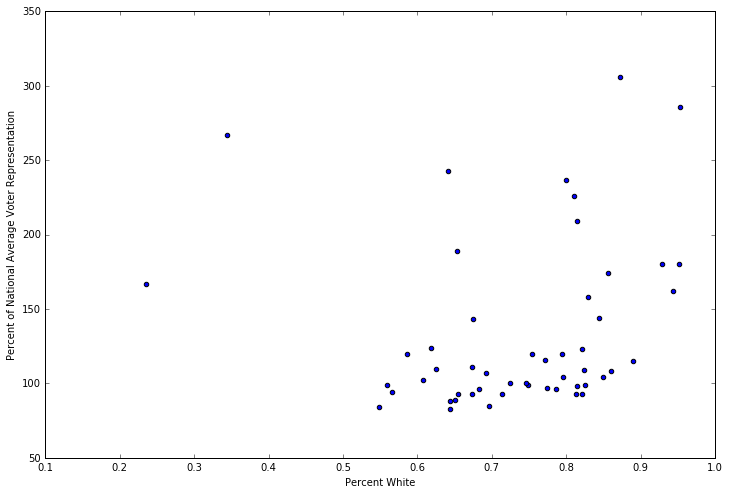

In [71]:
plt.figure(figsize=(12,8))
plt.scatter(state_pop.percent_white, state_pop.ec_votes_per_voter_percent_of_average)
plt.xlabel('Percent White')
plt.ylabel('Percent of National Average Voter Representation')
plt.show()

In [69]:
state_pop[state_pop.percent_white < .5].state

7     District of Columbia
11                  Hawaii
Name: state, dtype: object